In [1]:
import numpy as np
import xarray as xr

import sys
sys.path.append('/Volumes/KT-TOSHIBA/ENOI/CODE')
import enoi_functions as enoi
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

mdata='/Volumes/KT-TOSHIBA/ENOI/sorted_model_data/'

ulev = [0, 100, 500, 1000]
llev = [100, 500, 1000, 2000]

lon = np.arange(0.5,360.5)
lat = np.arange(-89.5,90.5)

mdict = {'lat':'lat', 'lon':'lon', 'lev':'lev', 'lev_bnds':'lev_bnds'}

In [2]:
from dask.distributed import Client
client = Client('tcp://127.0.0.1:8786')

In [3]:
def skill_depth(ul,ll):
    mdata='/Volumes/KT-TOSHIBA/ENOI/sorted_model_data/'
    m0 = xr.open_dataset('/Volumes/KT-TOSHIBA/ENOI/CMIP6/forcings/mol1.nc', decode_times=False)
    pco2 = m0.mole_fraction_of_carbon_dioxide_in_air[-60:,0]
    pco2_extended = np.tile(pco2.data - np.nanmean(pco2.data), int(1800/60))
    test_mask = np.load(f'{mdata}mask_{ll}.npy')

    dissic_l = np.load(f'{mdata}dic_{ll}.npy')
    thetao_l = np.load(f'{mdata}thetao_{ll}.npy')
    so_l = np.load(f'{mdata}so_{ll}.npy')
    
    drift_dissic_l = np.load(f"drift_ts_dissic{ll:04d}.npy")
    drift_thetao_l = np.load(f"drift_ts_thetao{ll:04d}.npy")
    drift_so_l = np.load(f"drift_ts_so{ll:04d}.npy")

    if ul == 0:
        ens_dic =  xr.DataArray(data=(dissic_l - drift_dissic_l))
        ens_theta =  xr.DataArray(data=(thetao_l - drift_thetao_l))
        ens_sal = xr.DataArray(data=(so_l - drift_so_l))
    else:
        dissic_u = np.load(f'{mdata}dic_{ul}.npy')
        thetao_u = np.load(f'{mdata}thetao_{ul}.npy')
        so_u = np.load(f'{mdata}so_{ul}.npy')
        
        drift_dissic_u = np.load(f"drift_ts_dissic{ul:04d}.npy")
        drift_thetao_u = np.load(f"drift_ts_thetao{ul:04d}.npy")
        drift_so_u = np.load(f"drift_ts_so{ul:04d}.npy")
        
        ens_dic =  xr.DataArray(data=(dissic_l - drift_dissic_l - dissic_u + drift_dissic_u))
        ens_theta =  xr.DataArray(data=(thetao_l - drift_thetao_l - thetao_u + drift_thetao_u))
        ens_sal = xr.DataArray(data=(so_l - drift_so_l - so_u + drift_so_u))
    
    coeff = xr.open_dataset(f'c_{ul}_{ll}_sens.nc')

    dic_resid = ens_dic - ens_dic.mean(axis=0)
    theta_resid = ens_theta - ens_theta.mean(axis=0)
    so_resid = ens_sal - ens_sal.mean(axis=0)

    rmse_ensfit = np.zeros((6,180,360))
    rmse_prior = np.zeros((6,180,360))
    rmse_ensfit_detrend = np.zeros((6,180,360))
    rmse_prior_detrend = np.zeros((6,180,360))
    
    eps_glob = np.zeros(6)
    eps_glob_detr = np.zeros(6)
   
    mask = np.tile(test_mask, (300,1,1))

    for i in np.arange(0,6):
        ri_i = np.arange(i*5*60,(i+1)*5*60)
        dic_truth = dic_resid[ri_i,:,:]
        dic_recon_enscov = coeff.cT[i,:,:].data * theta_resid[ri_i,:,:] + \
            coeff.cS[i,:,:].data * ens_sal[ri_i,:,:] + \
                coeff.cCO2[i,:,:].data * np.transpose(np.tile(pco2_extended[:300],(360,180,1)),(2,1,0))

        true1 = np.ma.masked_where(1-mask, dic_truth)
        recon1 = np.ma.masked_where(1-mask, dic_recon_enscov)
    
        dic_truth_detrend = enoi.detrend_ens(dic_truth, 0, 60)
        dic_recon_detrend = enoi.detrend_ens(dic_recon_enscov, 0, 60)

        rmse_ensfit[i,:,:] = enoi.RMSE(dic_truth,dic_recon_enscov,0)
        rmse_prior[i,:,:] = enoi.RMSE(dic_truth,0,0)
    
        rmse_prior_detrend[i,:,:] = enoi.RMSE(dic_truth_detrend,0,0)
        rmse_ensfit_detrend[i,:,:] = enoi.RMSE(dic_truth_detrend,dic_recon_detrend,0)
        
        #eps_glob[i], eps_glob_detr[i] = enoi.RMSE_global(true1, recon1)

    skill = np.nanmean((rmse_prior-rmse_ensfit)/rmse_prior,axis=0)
    skill_d = np.nanmean((rmse_prior_detrend-rmse_ensfit_detrend)/rmse_prior_detrend,axis=0)
    
    rmse_avg_prior = np.nanmean(rmse_prior, axis=0)
    rmse_avg_enoi = np.nanmean(rmse_ensfit, axis=0)
    
    return skill, skill_d, rmse_avg_prior, rmse_avg_enoi

In [4]:
skill_full = np.ones((4,180,360))*np.nan
skill_detrend = np.ones((4,180,360))*np.nan
rmse_prior = np.ones((4,180,360))*np.nan
rmse_ensfit = np.ones((4,180,360))*np.nan

for i in np.arange(4):
    ul=ulev[i]
    ll=llev[i]
    
    skill_full[i,:,:], skill_detrend[i,:,:], rmse_prior[i,:,:], rmse_ensfit[i,:,:] = skill_depth(ul,ll)
    print(f'Reconstruction statistics done for layer between {ul}m and {ll}m')

/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:70: RuntimeWarning: invalid value encountered in divide
  skill = np.nanmean((rmse_prior-rmse_ensfit)/rmse_prior,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:70: RuntimeWarning: Mean of empty slice
  skill = np.nanmean((rmse_prior-rmse_ensfit)/rmse_prior,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: divide by zero encountered in divide
  skill_d = np.nanmean((rmse_prior_detrend-rmse_ensfit_detrend)/rmse_prior_detrend,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: invalid value encountered in divide
  skill_d = np.nanmean((rmse_prior_detrend-rmse_ensfit_detrend)/rmse_prior_detrend,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: Mean of empty slice
  skill_d = np.nanmean((rmse_prior_detrend-rmse_e

Reconstruction statistics done for layer between 0m and 100m


/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:70: RuntimeWarning: invalid value encountered in divide
  skill = np.nanmean((rmse_prior-rmse_ensfit)/rmse_prior,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:70: RuntimeWarning: Mean of empty slice
  skill = np.nanmean((rmse_prior-rmse_ensfit)/rmse_prior,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: divide by zero encountered in divide
  skill_d = np.nanmean((rmse_prior_detrend-rmse_ensfit_detrend)/rmse_prior_detrend,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: invalid value encountered in divide
  skill_d = np.nanmean((rmse_prior_detrend-rmse_ensfit_detrend)/rmse_prior_detrend,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: Mean of empty slice
  skill_d = np.nanmean((rmse_prior_detrend-rmse_e

Reconstruction statistics done for layer between 100m and 500m


/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:70: RuntimeWarning: invalid value encountered in divide
  skill = np.nanmean((rmse_prior-rmse_ensfit)/rmse_prior,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:70: RuntimeWarning: Mean of empty slice
  skill = np.nanmean((rmse_prior-rmse_ensfit)/rmse_prior,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: divide by zero encountered in divide
  skill_d = np.nanmean((rmse_prior_detrend-rmse_ensfit_detrend)/rmse_prior_detrend,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: invalid value encountered in divide
  skill_d = np.nanmean((rmse_prior_detrend-rmse_ensfit_detrend)/rmse_prior_detrend,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: Mean of empty slice
  skill_d = np.nanmean((rmse_prior_detrend-rmse_e

Reconstruction statistics done for layer between 500m and 1000m


/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:70: RuntimeWarning: invalid value encountered in divide
  skill = np.nanmean((rmse_prior-rmse_ensfit)/rmse_prior,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:70: RuntimeWarning: Mean of empty slice
  skill = np.nanmean((rmse_prior-rmse_ensfit)/rmse_prior,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: divide by zero encountered in divide
  skill_d = np.nanmean((rmse_prior_detrend-rmse_ensfit_detrend)/rmse_prior_detrend,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: invalid value encountered in divide
  skill_d = np.nanmean((rmse_prior_detrend-rmse_ensfit_detrend)/rmse_prior_detrend,axis=0)
/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/2149665520.py:71: RuntimeWarning: Mean of empty slice
  skill_d = np.nanmean((rmse_prior_detrend-rmse_e

Reconstruction statistics done for layer between 1000m and 2000m


In [5]:
newcmp = enoi.n_cmap()

mdata = '/Volumes/KT-TOSHIBA/ENOI/sorted_model_data/'
test_mask_100 = np.load(f'{mdata}mask_100.npy')
test_mask_500 = np.load(f'{mdata}mask_500.npy')
test_mask_1000 = np.load(f'{mdata}mask_1000.npy')
test_mask_2000 = np.load(f'{mdata}mask_2000.npy')

test_mask_500[test_mask_500 ==0] = np.nan
test_mask_1000[test_mask_1000 ==0] = np.nan
test_mask_2000[test_mask_2000 ==0] = np.nan

dissic_SORTED = np.load(f'{mdata}dic_100.npy')
_, l_100 = enoi.create_mask(dissic_SORTED, f'{mdata}mask_100.npy')
_, l_500 = enoi.create_mask(dissic_SORTED, f'{mdata}mask_500.npy')
_, l_1000 = enoi.create_mask(dissic_SORTED, f'{mdata}mask_1000.npy')
_, l_2000 = enoi.create_mask(dissic_SORTED, f'{mdata}mask_2000.npy')
##############################################################################

/Volumes/KT-TOSHIBA/ENOI/CODE/enoi_functions.py:94: RuntimeWarning: invalid value encountered in divide
  test1 = np.isnan(np.mean(input_file/input_file, axis=0)) # find where model ensemble doesnt always have data


/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_79354/4203127607.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


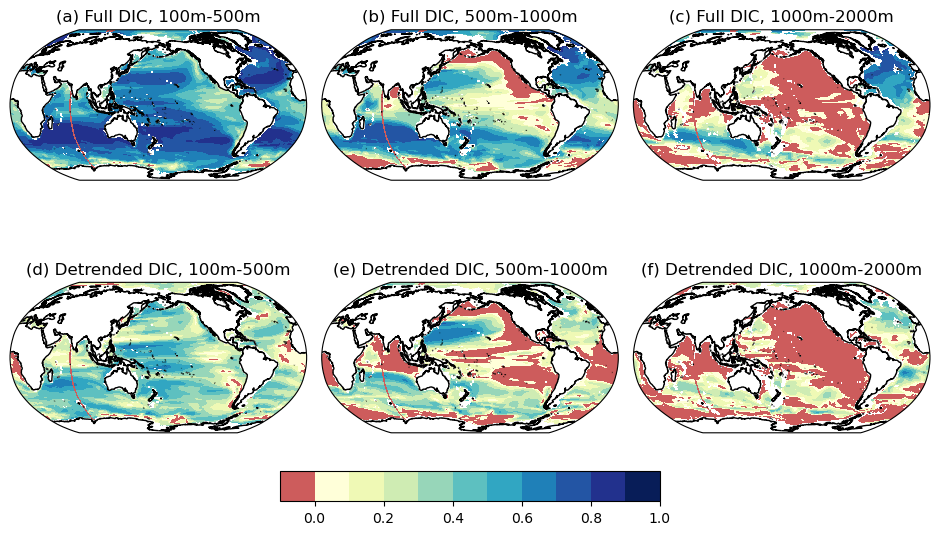

In [7]:
fig = plt.figure(figsize=(9.5, 6))

ax2 = plt.subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=180))
plt.title('(a) Full DIC, 100m-500m')
im2 = ax2.pcolormesh(lon, lat, np.ma.masked_where(l_500,skill_full[1,:,:]),
                   vmin=-.1, vmax=1, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
                   cmap=newcmp)
ax2.coastlines('50m')

ax3 = plt.subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=180))
plt.title('(b) Full DIC, 500m-1000m')
im3 = ax3.pcolormesh(lon, lat, np.ma.masked_where(l_1000,skill_full[2,:,:]),
                   vmin=-.1, vmax=1, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
                   cmap=newcmp)
ax3.coastlines('50m')

ax4 = plt.subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=180))
plt.title('(c) Full DIC, 1000m-2000m')
im4 = ax4.pcolormesh(lon, lat, np.ma.masked_where(l_2000,skill_full[3,:,:]),
                   vmin=-.1, vmax=1, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
                   cmap=newcmp)
ax4.coastlines('50m')

ax2a = plt.subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=180))
plt.title('(d) Detrended DIC, 100m-500m')
im2a = ax2a.pcolormesh(lon, lat, np.ma.masked_where(l_500,skill_detrend[1,:,:]),
                   vmin=-.1, vmax=1, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
                   cmap=newcmp)
ax2a.coastlines('50m')

ax3a = plt.subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=180))
plt.title('(e) Detrended DIC, 500m-1000m')
im3a = ax3a.pcolormesh(lon, lat, np.ma.masked_where(l_1000,skill_detrend[2,:,:]),
                   vmin=-.1, vmax=1, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
                   cmap=newcmp)
ax3a.coastlines('50m')

ax4a = plt.subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=180))
plt.title('(f) Detrended DIC, 1000m-2000m')
im4a = ax4a.pcolormesh(lon, lat, np.ma.masked_where(l_2000,skill_detrend[3,:,:]),
                   vmin=-.1, vmax=1, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None), 
                   cmap=newcmp)
ax4a.coastlines('50m')

ax_cbar1 = fig.add_axes([0.3, 0.05, .4, 0.05])
fig.colorbar(im4a, cax=ax_cbar1, orientation="horizontal", pad=0.2)
plt.tight_layout()
#plt.savefig('pc_manuscript_figures/improv_dense_depth.png', format='png', dpi=150, bbox_inches="tight")

/var/folders/gm/xbgrc7fs3wx5_dxmwj00n8lm0000gn/T/ipykernel_8706/1179060469.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


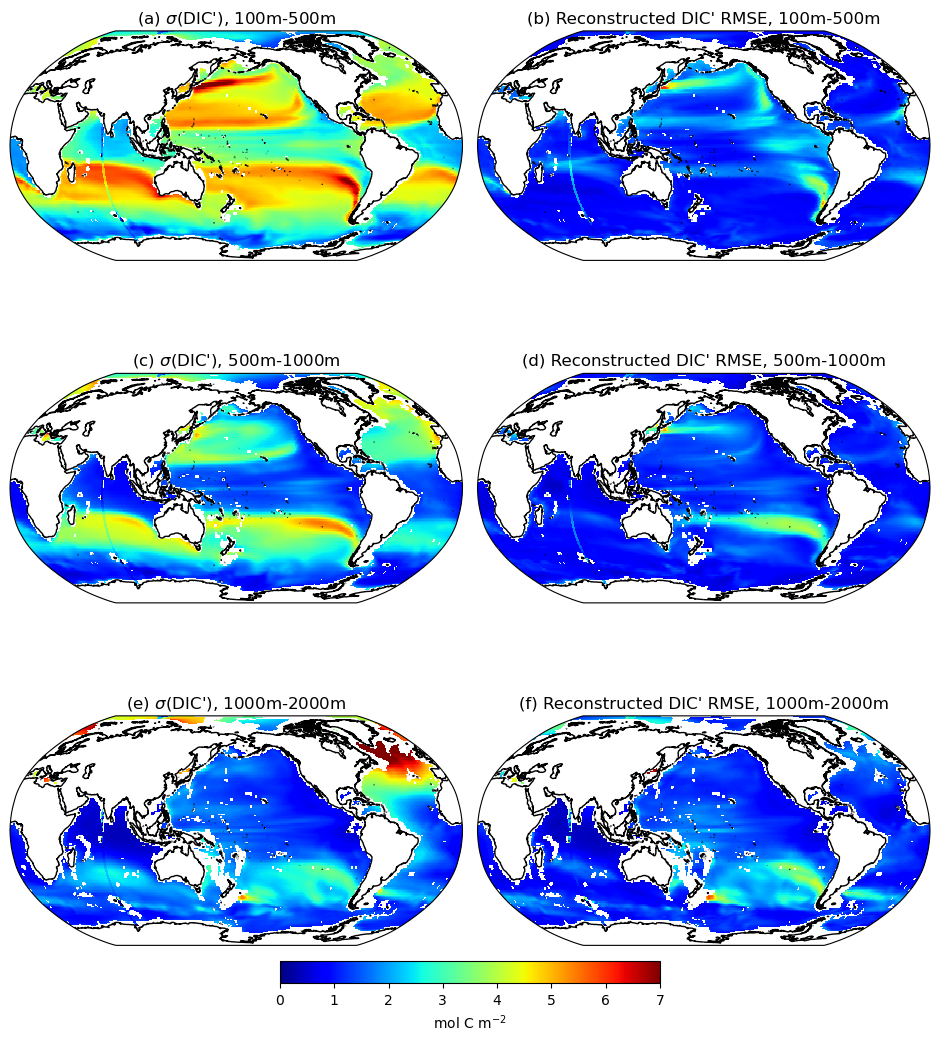

In [23]:
fig = plt.figure(figsize=(9.5, 11))

ax2 = plt.subplot(3, 2, 1, projection=ccrs.Robinson(central_longitude=180))
plt.title("(a) $\sigma$(DIC'), 100m-500m")
im2 = ax2.pcolormesh(lon, lat, np.ma.masked_where(l_500,rmse_prior[1,:,:]),
                   vmin=0, vmax=7, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None),
                    cmap=plt.get_cmap("jet"))
ax2.coastlines('50m')

ax2a = plt.subplot(3, 2, 2, projection=ccrs.Robinson(central_longitude=180))
plt.title("(b) Reconstructed DIC' RMSE, 100m-500m")
im2a = ax2a.pcolormesh(lon, lat, np.ma.masked_where(l_500,rmse_ensfit[1,:,:]),
                   vmin=0, vmax=7, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None),
                    cmap=plt.get_cmap("jet"))
ax2a.coastlines('50m')
#
#
ax3 = plt.subplot(3, 2, 3, projection=ccrs.Robinson(central_longitude=180))
plt.title("(c) $\sigma$(DIC'), 500m-1000m")
im3 = ax3.pcolormesh(lon, lat, np.ma.masked_where(l_1000,rmse_prior[2,:,:]),
                   vmin=0, vmax=7, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None),
                    cmap=plt.get_cmap("jet"))
ax3.coastlines('50m')

ax3a = plt.subplot(3, 2, 4, projection=ccrs.Robinson(central_longitude=180))
plt.title("(d) Reconstructed DIC' RMSE, 500m-1000m")
im3a = ax3a.pcolormesh(lon, lat, np.ma.masked_where(l_1000,rmse_ensfit[2,:,:]),
                   vmin=0, vmax=7, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None),
                    cmap=plt.get_cmap("jet"))
ax3a.coastlines('50m')
#
#
ax4 = plt.subplot(3, 2, 5, projection=ccrs.Robinson(central_longitude=180))
plt.title("(e) $\sigma$(DIC'), 1000m-2000m")
im4 = ax4.pcolormesh(lon, lat, np.ma.masked_where(l_2000,rmse_prior[3,:,:]),
                   vmin=0, vmax=7, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None),
                    cmap=plt.get_cmap("jet"))
ax4.coastlines('50m')

ax4a = plt.subplot(3, 2, 6, projection=ccrs.Robinson(central_longitude=180))
plt.title("(f) Reconstructed DIC' RMSE, 1000m-2000m")
im4a = ax4a.pcolormesh(lon, lat, np.ma.masked_where(l_2000,rmse_ensfit[3,:,:]),
                   vmin=0, vmax=7, 
                   transform=ccrs.PlateCarree(central_longitude=0.0, globe=None),
                    cmap=plt.get_cmap("jet"))
ax4a.coastlines('50m')

ax_cbar1 = fig.add_axes([0.3, 0.05, .4, 0.02])
fig.colorbar(im4a, cax=ax_cbar1, orientation="horizontal", pad=0.2, label="mol C m$^{-2}$")
plt.tight_layout()
plt.savefig('pc_manuscript_figures/supp_improv_dense_depth_absolute.png', format='png', dpi=150, bbox_inches="tight")